# Advanced Machine Learning and Artificial Intelligence (MScA 32017)

# Project: Satellite Imagery Feature Detection

## Notebook 1: Basics of Image Transformations Using Keras

### Yuri Balasanov, Mihail Tselishchev, &copy; iLykei 2018

##### Main text: Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurelien Geron, &copy; Aurelien Geron 2017, O'Reilly Media, Inc


This notebook shows important transformations needed for construction of U-Net for image segmentation: 
- *Convolution*: Extracting from the image feature maps using hierarchical scanning process  
- *Pooling*: Downsizing feature maps by one or several pooling kernels, like max or mean 
- *Up-Sampling*: Increasing size or sample rate of the input
- *Up-Convolution*: A type of convolution that combines upsampling with filtering
- *Data augmentation*: creation of additional training images by rotation

Rather than training models this notebook just defines and predicts the models to see more clearly what the layers actually do.

## Plotting image

In [1]:
%matplotlib inline

In [2]:
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, \
UpSampling2D, Conv2DTranspose
from keras.utils import plot_model

Using TensorFlow backend.


First, read image with library [imageio](https://pypi.python.org/pypi/imageio) (install it via *'conda install imageio'* in Terminal).

In [3]:
import imageio
x = imageio.imread('~/Datasets/32017/cat.jpeg')
x.shape  

(300, 400, 3)

Note that in the shape of the image the dimensions of the image come first $(300 \times 400)$ and the number of channels is the last dimension $(3)$.

Plot the image:

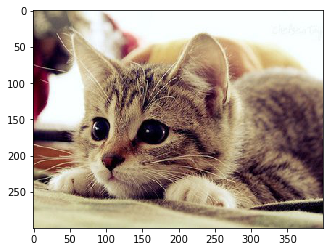

In [4]:
import matplotlib.pyplot as plt
plt.imshow(x)
plt.savefig('cat.png')

## Convolution layer

Assemble a model containing only input and convolutional layer.

Convolutional layer is [defined by](https://keras.io/layers/convolutional/):

`keras.layers.Conv2D(filters, kernel_size, strides=(1, 1), padding='valid', activation=None, use_bias=True, kernel_initializer='glorot_uniform', ...)`

where:

- filters: Integer, the dimensionality of the output space (i.e. the number of filters in the convolution) 
- kernel_size: An integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions  
- strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the width and height. Can be a single integer to specify the same value for all spatial dimensions 
- padding: One of "valid" or "same" (case-insensitive). In case of "valid" pixels on the edge of image that do not make complete kernel are dropped; in case of "same" they are padded by zeros to make a complete kernel.
- activation: Activation function to use (see activations). If not specified, no activation is applied (ie. "linear" activation: a(x) = x)
- use_bias: Boolean, whether the layer uses a bias vector
- kernel_initializer: Initializer for the kernel weights matrix (see initializers).

Create convolution layer with 4 filters, kernel size $(21 \times 21)$ and strides $(1 \times 1)$.

In [5]:
inputs = Input((None, None, 3))
conv = Conv2D(filters=4, kernel_size=(21, 21), strides=(1,1), 
              padding='same', use_bias=False)(inputs)
conv_model = Model(inputs=inputs, outputs=conv)

W0716 14:19:36.487339 4484081088 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 14:19:36.533924 4484081088 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 14:19:36.550397 4484081088 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Plot the network.

If the following code results in an error message because pydot and graphviz are not properly installed [this post](https://www.codesofinterest.com/2017/02/visualizing-model-structures-in-keras.html) may help.

In [6]:
plot_model(conv_model, to_file='simple_conv_model.png', show_shapes=True)

![Con Model](simple_conv_model.png)

See shapes of input and output in the summary

In [7]:
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, None, None, 4)     5292      
Total params: 5,292
Trainable params: 5,292
Non-trainable params: 0
_________________________________________________________________


There are $5292=21 \times 21 \times 3 \times 4$ parameters in the constructed convolution layer. By default they are randomly initialized. 

Apply the convolution layer with such randomly initialized filters to the image:

W0716 14:19:36.749444 4484081088 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2741: The name tf.Session is deprecated. Please use tf.compat.v1.Session instead.

W0716 14:19:36.755388 4484081088 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



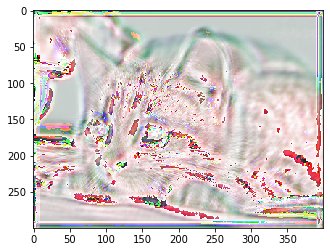

In [8]:
batch = np.expand_dims(x, 0)  # model.predict expects not one image, but a batch of images
y0 = conv_model.predict(batch)[0].astype('uint8')

plt.imshow(y0)
#plt.savefig('cat0.png')

It may look creepy sometimes! <br>

Now, instead of random initialization of the layer fix convolution weights.

Reduce the size of the network to 3 filters: one will be applied to each channel.

First, apply horizontal filter and pass it to the layer without training.

In [9]:
inputs = Input((None, None, 3))
conv = Conv2D(filters=3, kernel_size=(21, 21), strides=(1,1), 
              padding='same', use_bias=False)(inputs)
conv_model = Model(inputs=inputs, outputs=conv)
conv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, None, None, 3)     3969      
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


In [10]:
horizontal_filter = np.zeros(shape=(21,21,3,3))
for i in range(3):
    horizontal_filter[10,:,i,i] = 1.0/21.0
# fixing convolution weights
conv_model.layers[1].set_weights([horizontal_filter])

Apply convolution with horizontal filter to each channel of the image:

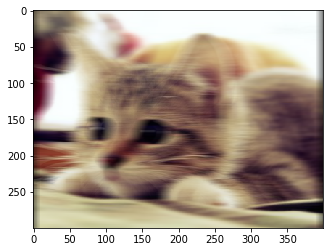

In [11]:
y1 = conv_model.predict(batch)[0].astype('uint8')
plt.imshow(y1)
#plt.savefig('cat1.png')

Note that horizontal lines (such as cat's whiskers) get enhanced, while everything else gets blurred.

Create a vertical filter and apply it to the same image.

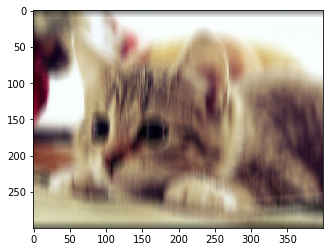

In [12]:
vertical_filter = np.zeros(shape=(21,21,3,3))
for i in range(3):
    vertical_filter[:,10,i,i] = 1.0/21.0
conv_model.layers[1].set_weights([vertical_filter])
y2 = conv_model.predict(batch)[0].astype('uint8')
plt.imshow(y2)
plt.savefig('cat2.png')

Note that this time vertical lines (such as cat's claws or vertical fur stripes) get enhanced, while everything else gets blurred.

## MaxPooling Layer

Creating [max pooling](https://faroit.github.io/keras-docs/1.1.2/layers/pooling/) layer   is done by:

`keras.layers.pooling.MaxPooling2D(pool_size=(2, 2), strides=None, border_mode='valid', dim_ordering='default')`


- pool_size: tuple of 2 integers, factors by which to downscale (vertical, horizontal). Default value (2, 2) will halve the image in each dimension.
- strides: tuple of 2 integers, or None. Strides values. If None, it will default to pool_size.
- border_mode: 'valid' or 'same'.
- dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension (the depth) is at index 1, in 'tf' mode is it at index 3. It defaults to the `image_dim_ordering` value found in Keras config file at ~/.keras/keras.json. If you never set it, then it will be "tf".

Assemble a model with only an input and max pooling layer.

In [13]:
inputs = Input((None, None, 3))
maxpool = MaxPooling2D(pool_size=(2, 2))(inputs)
maxpool_model = Model(inputs=inputs, outputs=maxpool)
maxpool_model.summary()

W0716 14:19:38.590027 4484081088 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, None, None, 3)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


In [14]:
plot_model(maxpool_model, to_file='simple_maxpool_model.png', show_shapes=True)

![Maxpool Mod](simple_maxpool_model.png)

Apply MaxPool to the cat image:

(300, 400, 3)
(150, 200, 3)


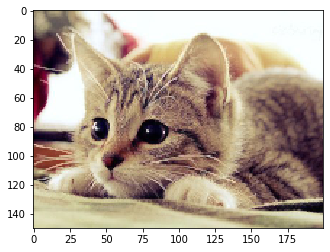

In [15]:
y3 = maxpool_model.predict(batch)[0].astype('uint8')
print(x.shape)
print(y3.shape)
plt.imshow(y3)

Note that MaxPooling transformation downscales original image in each dimension according to *'pool_size'*.

## UpSampling Layer

Up-sampling is a process of enlarging the image. <br>
Up-sampling belongs to a general class of resampling methods.
Typically it is done in 2 steps:
1. Making smooth interpolation of the original image;
2. Sampling the interpolated image with higher rate.

Upsampling layer can be [defined](https://faroit.github.io/keras-docs/1.0.1/layers/convolutional/) by:

`keras.layers.convolutional.UpSampling2D(size=(2, 2), dim_ordering='th')`

Arguments:

- size: tuple of 2 integers. The upsampling factors for rows and columns.
- dim_ordering: 'th' or 'tf'. In 'th' mode, the channels dimension (the depth) is at index 1, in 'tf' mode is it at index 3.

Input shape

4D tensor with shape: **(samples, channels, rows, cols)** if dim_ordering='th' or 4D tensor with shape: **(samples, rows, cols, channels)** if dim_ordering='tf'.

Output shape

4D tensor with shape: **(samples, channels, upsampled_rows, upsampled_cols)** if dim_ordering='th' or 4D tensor with shape: **(samples, upsampled_rows, upsampled_cols, channels)** if dim_ordering='tf'

Assemble a model with input and upsampling layer

In [16]:
inputs = Input((None, None, 3))
upsample = UpSampling2D(size=(2, 2))(inputs)
upsample_model = Model(inputs=inputs, outputs=upsample)
plot_model(upsample_model, to_file='simple_upsample_model.png', show_shapes=True)
upsample_model.summary()

W0716 14:19:39.137011 4484081088 deprecation_wrapper.py:119] From /Users/sshepa74/code/MScA/venv3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:2018: The name tf.image.resize_nearest_neighbor is deprecated. Please use tf.compat.v1.image.resize_nearest_neighbor instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, None, None, 3)     0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


![Simple Upsample](simple_upsample_model.png)

Apply UpSample to the cat image:

(300, 400, 3)
(600, 800, 3)


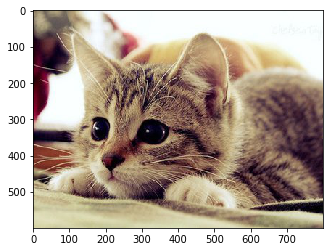

In [17]:
y4 = upsample_model.predict(batch)[0].astype('uint8')
print(x.shape)
print(y4.shape)
plt.imshow(y4)

Note that UpSample transformation upscales original image in each dimension.

### Up-Convolution (aka Transposed Convolution) Layer

Up-convolution applies filters to increase the image to the original size.

Up-convolution layer can be [defined](https://keras.io/layers/convolutional/) by:

`keras.layers.Conv2DTranspose(filters, kernel_size, strides=(1, 1), padding='valid', data_format=None, activation=None, use_bias=True, ...)`

Arguments

- filters: Integer, the dimensionality of the output space (i.e. the number of output filters in the convolution).
- kernel_size: An integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window. Can be a single integer to specify the same value for all spatial dimensions.
- strides: An integer or tuple/list of 2 integers, specifying the strides of the convolution along the width and height. Can be a single integer to specify the same value for all spatial dimensions. Specifying any stride value != 1 is incompatible with specifying any dilation_rate value != 1.
- padding: one of "valid" or "same" (case-insensitive).
- data_format: A string, one of channels_last (default) or channels_first. The ordering of the dimensions in the  inputs. channels_last corresponds to inputs with shape (batch, height, width, channels) while channels_first corresponds to inputs with shape (batch, channels, height, width). It defaults to the image_data_format value found in your Keras config file at ~/.keras/keras.json. If you never set it, then it will be "channels_last".
- activation: Activation function to use (see activations). If you don't specify anything, no activation is applied (ie. "linear" activation: a(x) = x).
- use_bias: Boolean, whether the layer uses a bias vector.

Input shape

4D tensor with shape: **(batch, channels, rows, cols)** if data_format='channels_first' or 4D tensor with shape: **(batch, rows, cols, channels)** if data_format='channels_last'.

Output shape

4D tensor with shape: **(batch, filters, new_rows, new_cols)** if data_format='channels_first' or 4D tensor with shape: **(batch, new_rows, new_cols, filters)** if data_format='channels_last'. rows and cols values might have changed due to padding.

Assemble a model with input and UpConv layer only.

In [18]:
inputs = Input((None, None, 3))
upconv = Conv2DTranspose(filters=3, kernel_size=(21, 21), strides=(2,2),
                         padding='same', use_bias=False)(inputs)
upconv_model = Model(inputs=inputs, outputs=upconv)
plot_model(upconv_model, to_file='simple_upconvol_model.png', show_shapes=True)
upconv_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, None, None, 3)     3969      
Total params: 3,969
Trainable params: 3,969
Non-trainable params: 0
_________________________________________________________________


![Upconvolut Model](simple_upconvol_model.png)

See the output of randomly initialized UpConvolution layer applied to the cat image:

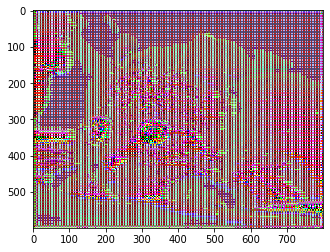

In [19]:
y5 = upconv_model.predict(batch)[0].astype('uint8')
plt.imshow(y5)

And now fix the weights of vertical filter:

In [20]:
upconv_model.layers[1].set_weights([vertical_filter])

(300, 400, 3)
(600, 800, 3)


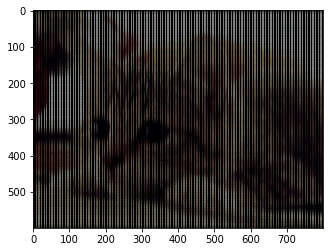

In [21]:
# apply upconvolution with vertical filter the image:
y6 = upconv_model.predict(batch)[0].astype('uint8')
print(x.shape)
print(y6.shape)
plt.imshow(y6)

Like upsampling, upconv layer doubles the size of the original image in each dimension. <br>
However, it is done in combination with filtering with as many parameters as convolution layer typically has. 

For more information check an [article by Vincent Dumoulin and Francesco Visin](https://arxiv.org/abs/1603.07285). Also visit [Keras documentation](https://keras.io/layers/convolutional/).

### Data Augmentation

Data augmentation is a very important method improving training of CNN. There are several ways of augmention of images.

Load the original image.

(300, 400, 3)

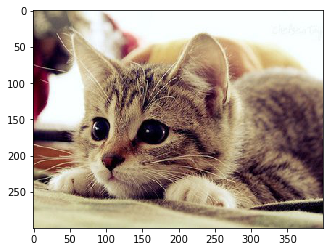

In [22]:
plt.imshow(x)
x.shape

Transpose images using one of several transformations:

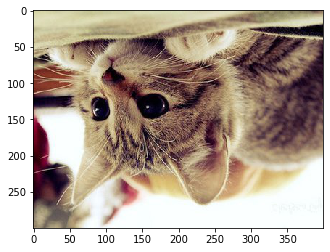

In [23]:
x1 = x[::-1,:,:] # first dimension in reverse order
plt.imshow(x1)

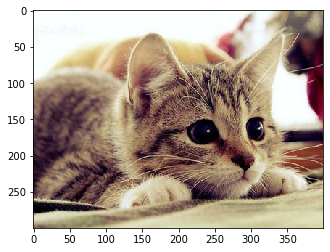

In [24]:
x2 = x[:,::-1,:] # second dimension in reverse order
plt.imshow(x2)

(400, 300, 3)

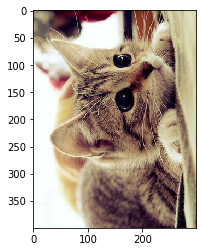

In [25]:
plt.imshow(x.transpose([1,0,2])) # reorder first 2 dimensions
x.transpose([1,0,2]).shape

A more flexible, but a slower way of augmentation uses package `pillow` or another similar package for image processing.    

Install package `pillow` as

`conda install -c anaconda pillow`.

Use it to rotate images.

In [26]:
import os

(300, 400, 3) (400, 300)


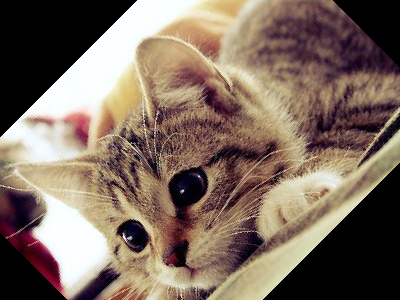

In [27]:
from PIL import Image
y=Image.open(os.path.expanduser('~/Datasets/32017/cat.jpeg'))
y2=y.rotate(45) # rotate counter clock-wise by 45 degrees
y2.save('cat2.jpeg') # save the image
print(x.shape,y2.size)
y2

Open the saved image using *imageio*

(300, 400, 3)


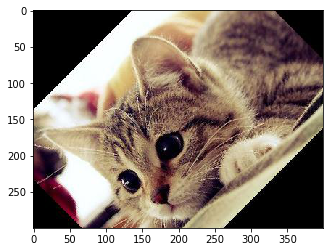

In [28]:
z = imageio.imread('cat2.jpeg')
print(z.shape)
plt.imshow(z)

Rotate in the opposite direction.

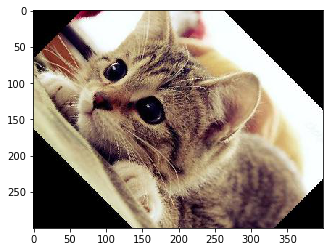

In [29]:
y3=y.rotate(-45)
y3.save('cat3.jpeg')
z = imageio.imread('cat3.jpeg')
plt.imshow(z)